# Unsupervised mosaic integration using Palette

**Palette** is designed to integrate mosaic data, which contains multimodal batches from different sequencing technologies, conditions, or species, embedding all cells into a common modality-agnostic low-dimensional space. 

In this tutorial, we applied Palette on human BMMC CITE-seq and 10x Multiome data from the [NeurIPS 2021 single-cell multimodal data benchmark](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122). For two technologies, 3 batches are selected for integration, respectively.

In [1]:
library(PaletteSC)
library(uwot)
library(cowplot)
library(RColorBrewer)
library(ggplot2)
library(RColorBrewer)
library(scattermore)
library(ggsci)

Loading required package: Matrix



## Load data

We read in the datasets, with rows as features and columns as cells for all modalities. The highly variable features (HVFs) are already selected and are used to perform integration. For the scRNA-seq data, highly variable genes (HVGs) were identified independently for each batch using FindVariableFeatures and taking the union of HVGs across batches. For scATAC-seq data, we remove the peaks on the sex chromosomes to ensure that the data is an appropriate input for any algorithm. It is worth mentioning that the Palette algorithm does not inherently require the removal of the peaks on the sex chromosomes. For ADT data, we kept all features as input.

In [2]:
options(future.globals.maxSize = 50 * 1024^3)
setwd('../')
path1 <- c('./CITE/s1d1_cite','./CITE/s1d2_cite','./CITE/s1d3_cite')
rna1.list <- list()
adt.list <- list()
for(i in 1:3){
  rna1.list[[i]] <- readRDS(paste0(path1[i],'/rna.rds'))
  adt.list[[i]] <- readRDS(paste0(path1[i],'/adt.rds'))
}
path2 <- c('./Multiome/s1d1_multi','./Multiome/s1d2_multi','./Multiome/s1d3_multi')
rna2.list <- list()
atac.list <- list()
for(i in 1:3){
  rna2.list[[i]] <- readRDS(paste0(path2[i],'/rna.rds'))
  atac.list[[i]] <- readRDS(paste0(path2[i],'/atac.rds'))
}

## Create a Palette object

The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for multimodal dataset.

**Palette** accepts data in **list format**, with each element representing a feature-by-cell data matrix. The modality and batch information for each input are provided through ```modals``` and ```samples```.

In [3]:
obj <- Create.Palette.Object(data.list = c(rna1.list,
                                             rna2.list,
                                             adt.list,
                                             atac.list), 
                               samples = c('CITE1','CITE2','CITE3',
                                           'Multiome1','Multiome2','Multiome3',
                                           'CITE1','CITE2','CITE3',
                                           'Multiome1','Multiome2','Multiome3'), 
                               modals = c("rna","rna","rna",
                                          "rna","rna","rna",
                                          "adt",'adt','adt',
                                          "atac","atac","atac"))
rm(rna1.list,rna2.list,adt.list,atac.list)

## Data preprocessing

For the scRNA-seq data, we performed standard log-normalization using the NormalizeData function from the Seurat R package. For the scATAC-seq data, we performed inverse document frequency (IDF)–based scaling followed by log normalization on the peak count matrix. And for the ADT data, we performed centered log ratio transformation.

In [4]:
obj <- Normalize.Data(obj,modal = "rna",normal.method = "LogNormalize")
obj <- Normalize.Data(obj,modal = "adt",normal.method = "CLR",margin = 2)
obj <- IDFLog.Data(obj,modal = "atac")

obj <- Add.HVFs(obj, modal = "rna")
obj <- Add.HVFs(obj, modal = "adt")
obj <- Add.HVFs(obj, modal = "atac")

Performing IDF and log normalization

No features provide, use all shared features by default.

No features provide, use all shared features by default.

No features provide, use all shared features by default.



## Clustering and representative cells sampling

Within each batch, **Palette** assigns cluster labels to cells using the Louvain algorithm. Next, **Palette** selects a subset of representative cells from each batch. Specifically, silhouette widths (SWs) are computed for all cells based on their clustering labels.
Within each clustering label, cells are ranked by their SW values, and the top 25% (by default) are selected. By sampling representative cells, **Palette** is more robust to the low representative cells and is more computationally effective than using all cells in subsequent calculations.

In [5]:
obj <- Find.Cluster(object = obj, 
                         modal = c("rna",'adt','atac'),
                         method = c("PCA",'PCA','SVD'))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5227
Number of edges: 225698

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8823
Number of communities: 19
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4978
Number of edges: 231403

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8812
Number of communities: 20
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6106
Number of edges: 293938

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8863
Number of communities: 19
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6224
Number of edges: 254503

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8763
Number of communities: 22
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6740
Number of edges: 301008

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8590
Number of communities: 18
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4279
Number of edges: 193627

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8816
Number of communities: 18
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5227
Number of edges: 247983

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8821
Number of communities: 21
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4978
Number of edges: 235618

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9084
Number of communities: 23
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6106
Number of edges: 284193

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9018
Number of communities: 20
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6224
Number of edges: 273837

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8677
Number of communities: 18
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6740
Number of edges: 283235

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8465
Number of communities: 20
Elapsed time: 0 seconds


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4279
Number of edges: 203296

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8534
Number of communities: 16
Elapsed time: 0 seconds


## Intra-modal joint dimensionality reduction using Bi-sPCA

**Palette** independently integrating each data modality across batches using **Bi-supervised Principal Component Analysis (Bi-sPCA)**, a new dimensionality reduction model aiming to disentangle biological signals from technical effects. **Bi-sPCA** operates on kernel representations of both biological and technical variation, learning a projection that maximizes biological variation in the embedding while minimizing unwanted technical effects.

```lambda``` balances the relative importance of biological effect and batch effect. If there are strong batch effects between batches, we recommend using a higher ```lambda``` value. To ensure numerical stability, **Palette** restricts 𝜆 to the range `[0,1)`.

When ```joint = TRUE```, all batches within a modality are projected into the same low-dimensional subspace, and the kernel matrix for **Bi-sPCA** is constructed within this space. When ```joint = FALSE```, the batches are reduced pairwise, and the kernel matrix is built based on these pairwise reductions. For datasets with strong batch heterogeneity, we recommend using ```joint = FALSE``` to achieve optimal integration.

**Palette** constructs the biological effect kernel using a threshold $T = max\{T_1,\; T_2\}$ to filter unreliable connections, where $T_1$ is a global modality-specific threshold and $T_2=cos(\theta_c+\theta_m)$ is an angular similarity constraint, where $\theta_c$ is the median angle of cell expression vectors within a batch, and $\theta_m$ is is a modality-specific angular offset which can set manually by ```Angle.var```.

To alleviate the computational burden of applying **Bi-sPCA** to datasets with extremely high feature dimensionality, such as scATAC-seq data, **Palette** incorporates two pre-dimensionality reduction strategies. If the matrix dimension exceeds ```RP_thresh```, pre-dimensionality reduction will be performed. ```pre.reduce``` controls whether to perform LSI (SVD) before **Bi-sPCA**. If ```pre.reduce=FALSE```, the random projection (RP) algorithm is used for pre-dimensionality reduction. For large-scale data, LSI pre-dimensionality reduction has higher computational efficiency than RP pre-dimensionality reduction.

In [6]:
obj <- Find.Subspace(obj,modal = c("rna",'adt','atac'),
                     lambda = list(0.8,0.8,0.5),
                     joint = TRUE,
                     sub.dims = list(1:40,1:30,1:30),
                     Angle.var = c(15,15,20),
                     pre.reduce = FALSE,
                     RP_thresh = 10000)

Performing pair-wise dimensionality reduction and L2 normalization, and identifying batch-specific cluster median cosine similarity. 


Done !

Performing pair-wise dimensionality reduction and L2 normalization, and identifying batch-specific cluster median cosine similarity. 


Done !

Performing pair-wise dimensionality reduction and L2 normalization, and identifying batch-specific cluster median cosine similarity. 


Done !

Performing random projection on modal atac. 




## MBG-guided inferring of missing modality matrices and Cross-batch alignment

**Palette** constructs a **mosaic bipartite graph (MBG)** to capture the structural topology of data. The **MBG** is an undirected, unweighted, and connected bipartite graph where nodes represent batches and modalities, and edges indicate the presence of a given modality in a batch. This graph sequentially connects the partially overlapping modalities across batches. For batches that lack measurements in specific modalities, **Palette** identifies shortest paths in the **MBG** that connect the batch to the missing modality. These paths define biologically informed propagation routes across the latent spaces of the shared modalities, enabling inference of low-dimensional representations for unobserved modalities by transferring information through matched neighbors across batches. **Palette** employs multiple paths to infer the missing data for each cell in a weighted approach. Finally, both real and inferred representations of all batches are jointly embedded into a unified low-dimensional space using **Bi-sPCA** again.

```origin.infer``` controls whether to infer the expression profiles. If ```origin.infer=TRUE```, the inferred expression profiles will be returned as new **Palette assays** in the **Palette object**.

In [7]:
obj <- Run.Palette(obj,origin.infer = FALSE)

Constructing MBG.

MBG Done!

Inferring missing modality matrices guided by MBG.


Performing inference for modal "atac" of  sample "CITE1" in embedding space.


Performing inference for modal "atac" of  sample "CITE2" in embedding space.


Performing inference for modal "atac" of  sample "CITE3" in embedding space.


Performing inference for modal "adt" of  sample "Multiome1" in embedding space.


Performing inference for modal "adt" of  sample "Multiome2" in embedding space.


Performing inference for modal "adt" of  sample "Multiome3" in embedding space.


MBG-guided inferring Done.


Cross-batch alignment.


Palette integration Done! 




## Visualization

In [8]:
meta <- readRDS('./meta.rds')
meta <- meta[,c(1,2,4)]
colnames(meta) <- c('Batch','CellType','Modality')

In [9]:
Palette_emb <- as.matrix(obj@Int.result[["bind"]][rownames(meta),])
Palette_umap = as.data.frame(umap(Palette_emb))
colnames(Palette_umap) = c("UMAP1", "UMAP2")
Palette_umap = cbind.data.frame(meta, Palette_umap)
fig.size = function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”


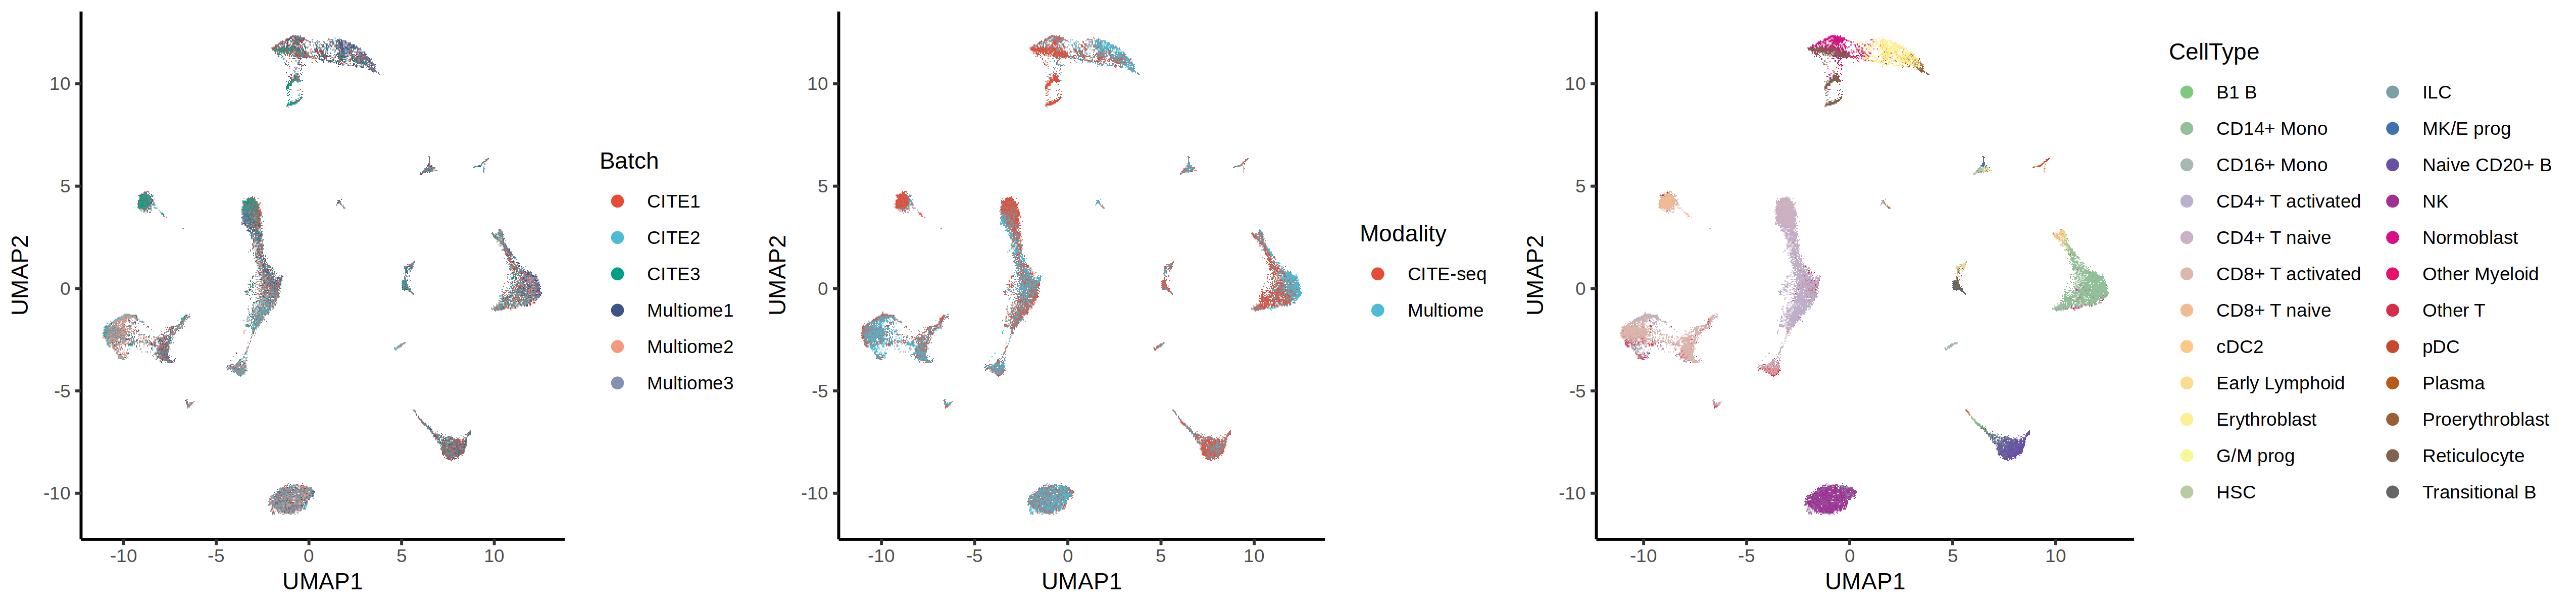

In [10]:
p1 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Batch)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

p2 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Modality)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

Colors <- colorRampPalette(brewer.pal(12, "Accent"))(24)
p3 <- ggplot(Palette_umap, aes(x = UMAP1, y = UMAP2, color = CellType)) +
  geom_scattermore(pointsize = 1) +   
  scale_color_manual(values = Colors) +  
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic() +
  theme(legend.position = "right")

fig.size(4,17)
plot_grid(p1, p2, p3,align = 'h', axis = "b",nrow = 1,rel_widths = c(5,5,7))

## Subsampling strategy for a large-scale dataset

For large-scale datasets, performing the cross-batch alignment step on the full dataset can substantially increase the computational burden. To address this issue, we provide an optional sampling strategy. The parameter `snn_full_max_cells` specifies a threshold on the dataset size: when the number of cells exceeds this threshold, the sampling strategy is automatically activated. The parameter `sample_ratio` controls the proportion of cells to be sampled and used in the cross-batch alignment step.

In [11]:
obj <- Run.Palette(obj,origin.infer = FALSE,
                   sample_ratio = 0.5, snn_full_max_cells = 200)

Constructing MBG.

MBG Done!

Inferring missing modality matrices guided by MBG.


Performing inference for modal "atac" of  sample "CITE1" in embedding space.


Performing inference for modal "atac" of  sample "CITE2" in embedding space.


Performing inference for modal "atac" of  sample "CITE3" in embedding space.


Performing inference for modal "adt" of  sample "Multiome1" in embedding space.


Performing inference for modal "adt" of  sample "Multiome2" in embedding space.


Performing inference for modal "adt" of  sample "Multiome3" in embedding space.


MBG-guided inferring Done.


Cross-batch alignment.


Palette integration Done! 




Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”


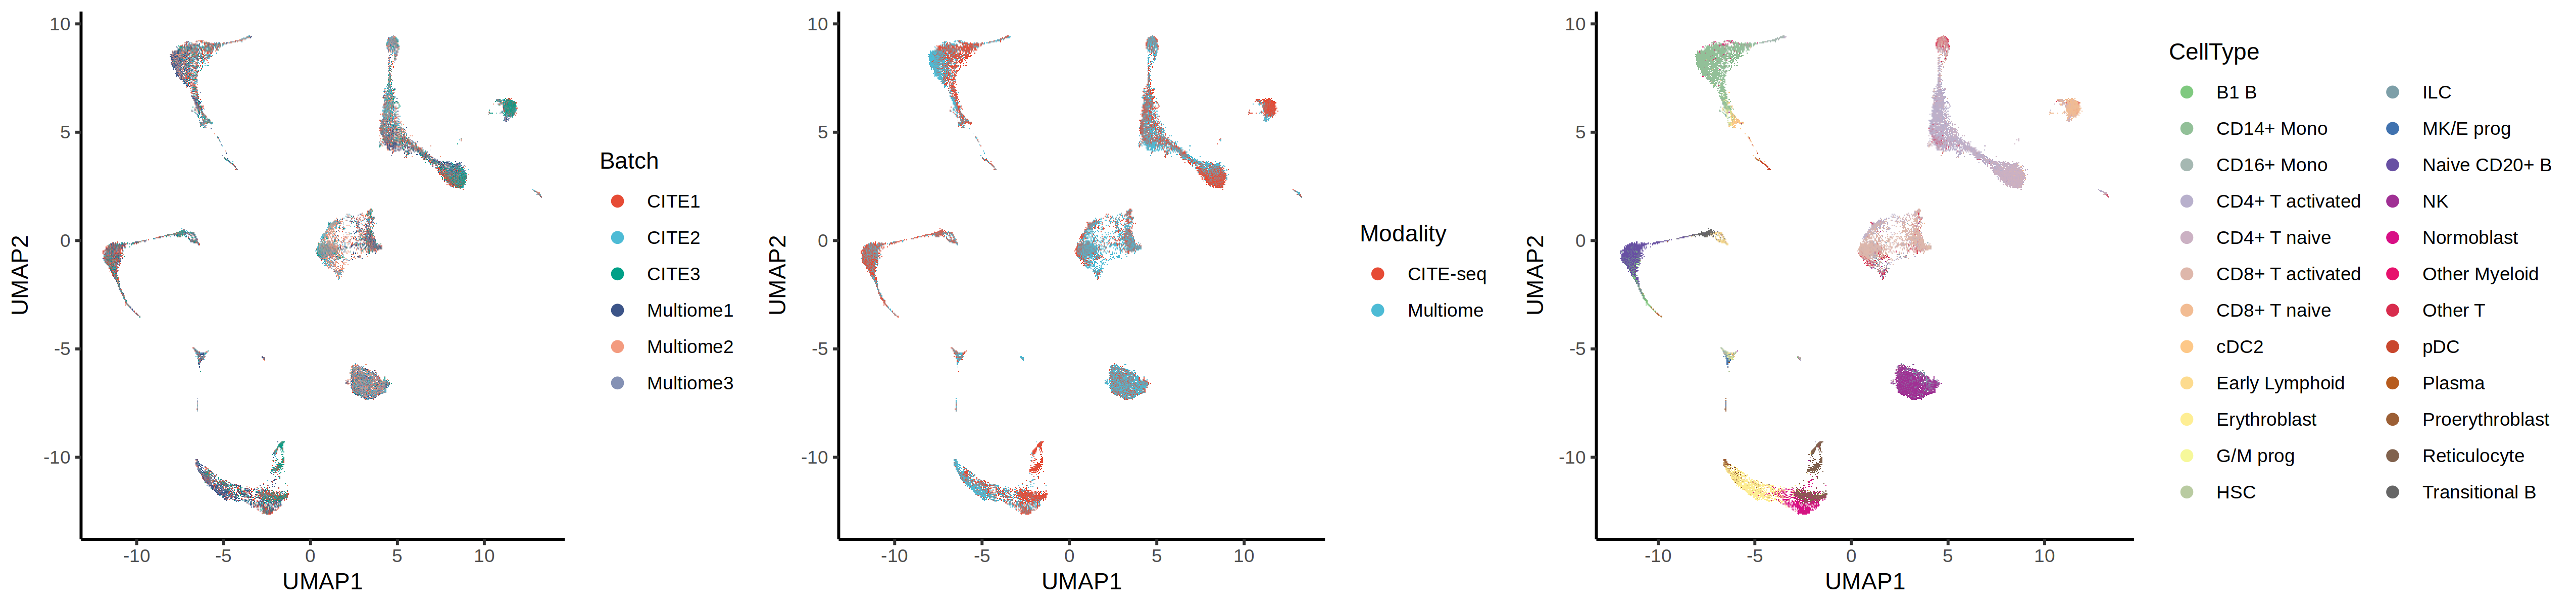

In [12]:
Palette_emb <- as.matrix(obj@Int.result[["bind"]][rownames(meta),])
Palette_umap = as.data.frame(umap(Palette_emb))
colnames(Palette_umap) = c("UMAP1", "UMAP2")
Palette_umap = cbind.data.frame(meta, Palette_umap)
fig.size = function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}
p1 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Batch)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

p2 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Modality)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

Colors <- colorRampPalette(brewer.pal(12, "Accent"))(24)
p3 <- ggplot(Palette_umap, aes(x = UMAP1, y = UMAP2, color = CellType)) +
  geom_scattermore(pointsize = 1) +   
  scale_color_manual(values = Colors) +  
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic() +
  theme(legend.position = "right")

fig.size(4,17)
plot_grid(p1, p2, p3,align = 'h', axis = "b",nrow = 1,rel_widths = c(5,5,7))

## Session Info

In [13]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/sqy/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggsci_3.0.3        scattermore_1.2    ggplot2_3.5.1      RColorBrewer_1.1-3
[5] cowplot_1.1.3      uwot_0.2.2         Matrix_1.6-5       PaletteSC_0.1.0   

loaded via a namespace (and not attached):
  [1] Seurat_4.4.0           Rtsne_0.17             colorspace_2.1-1      
  [4] deldir_2.0-4           ggridg